In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    recall_score, precision_score, f1_score, roc_curve, auc
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization, Embedding, Flatten, Input, Concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [2]:
# Funkce pro načtení a spojení dat
def load_and_merge_data(train_path, test_path, submit_path):
    train_df = pd.read_csv(train_path, sep=';')
    test_df = pd.read_csv(test_path, sep=';')
    submit_df = pd.read_csv(submit_path, sep=';')
    test_df = pd.concat([test_df, submit_df], axis=0, ignore_index=True).drop(columns=["idS"], errors='ignore')
    df_all = pd.concat([train_df, test_df], axis=0, ignore_index=True)
    return df_all

# Funkce pro předzpracování dat pomocí TF-IDF a imputace
def preprocess_data(df):
    target_column = df.columns[-1]
    X = df.drop(columns=[target_column])
    Y = df[target_column]

    # Imputace chybějících numerických hodnot
    imputer = SimpleImputer(strategy='mean')
    X_num_imputed = pd.DataFrame(imputer.fit_transform(X.select_dtypes(include=np.number)), columns=X.select_dtypes(include=np.number).columns)

    # Transformace textových dat pomocí TF-IDF
    if 'title' in df.columns:
        tfidf_vectorizer = TfidfVectorizer(max_features=10000)
        X_title_tfidf = tfidf_vectorizer.fit_transform(df['title'].astype(str).str.lower().fillna("")).toarray()
    else:
        X_title_tfidf = np.zeros((X.shape[0], 10000))

    # Standardizace numerických dat
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_num_imputed)

    # Sloučení numerických a textových dat
    X_final = np.hstack([X_num_scaled, X_title_tfidf])

    # Label encoding a one-hot encoding pro cílovou proměnnou
    label_encoder = LabelEncoder()
    Y_encoded = label_encoder.fit_transform(Y)
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    Y_onehot = one_hot_encoder.fit_transform(Y_encoded.reshape(-1, 1))

    return X_final, Y_onehot

# Funkce pro vytvoření modelu
def create_model(input_shape, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_shape=(input_shape,), kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Načtení a předzpracování dat
df_all = load_and_merge_data('train (2).csv', 'test (1).csv', 'evaluation.csv')
X, Y = preprocess_data(df_all)

# Rozdělení dat
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Vytvoření a trénování modelu
model = create_model(X_train.shape[1], y_train.shape[1])
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
history = model.fit(X_train, y_train, epochs=40, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

d:\DataScience2024\Projekty\Final_project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.7042 - loss: 1.1696 - val_accuracy: 0.9277 - val_loss: 0.9443 - learning_rate: 3.0000e-04
Epoch 2/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 38s 101ms/step - accuracy: 0.9364 - loss: 0.5933 - val_accuracy: 0.9327 - val_loss: 0.6400 - learning_rate: 3.0000e-04
Epoch 3/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.9601 - loss: 0.5133 - val_accuracy: 0.9364 - val_loss: 0.5620 - learning_rate: 3.0000e-04
Epoch 4/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - accuracy: 0.9714 - loss: 0.4563 - val_accuracy: 0.9353 - val_loss: 0.5606 - learning_rate: 3.0000e-04
Epoch 5/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 30s 120ms/step - accuracy: 0.9808 - loss: 0.4100 - val_accuracy: 0.9341 - val_loss: 0.5612 - learning_rate: 3.0000e-04
Epoch 6/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 31s 124ms/step - accuracy: 0.9846 - loss: 0.3760 - val_accuracy: 0.9310 - val_loss: 0.5550 - learning_rate: 3.0000e-04
Epoch 7/40
254/254 ━━━━━━━━━━━━━━━━━━━━ 37s 146m

254/254 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
254/254 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


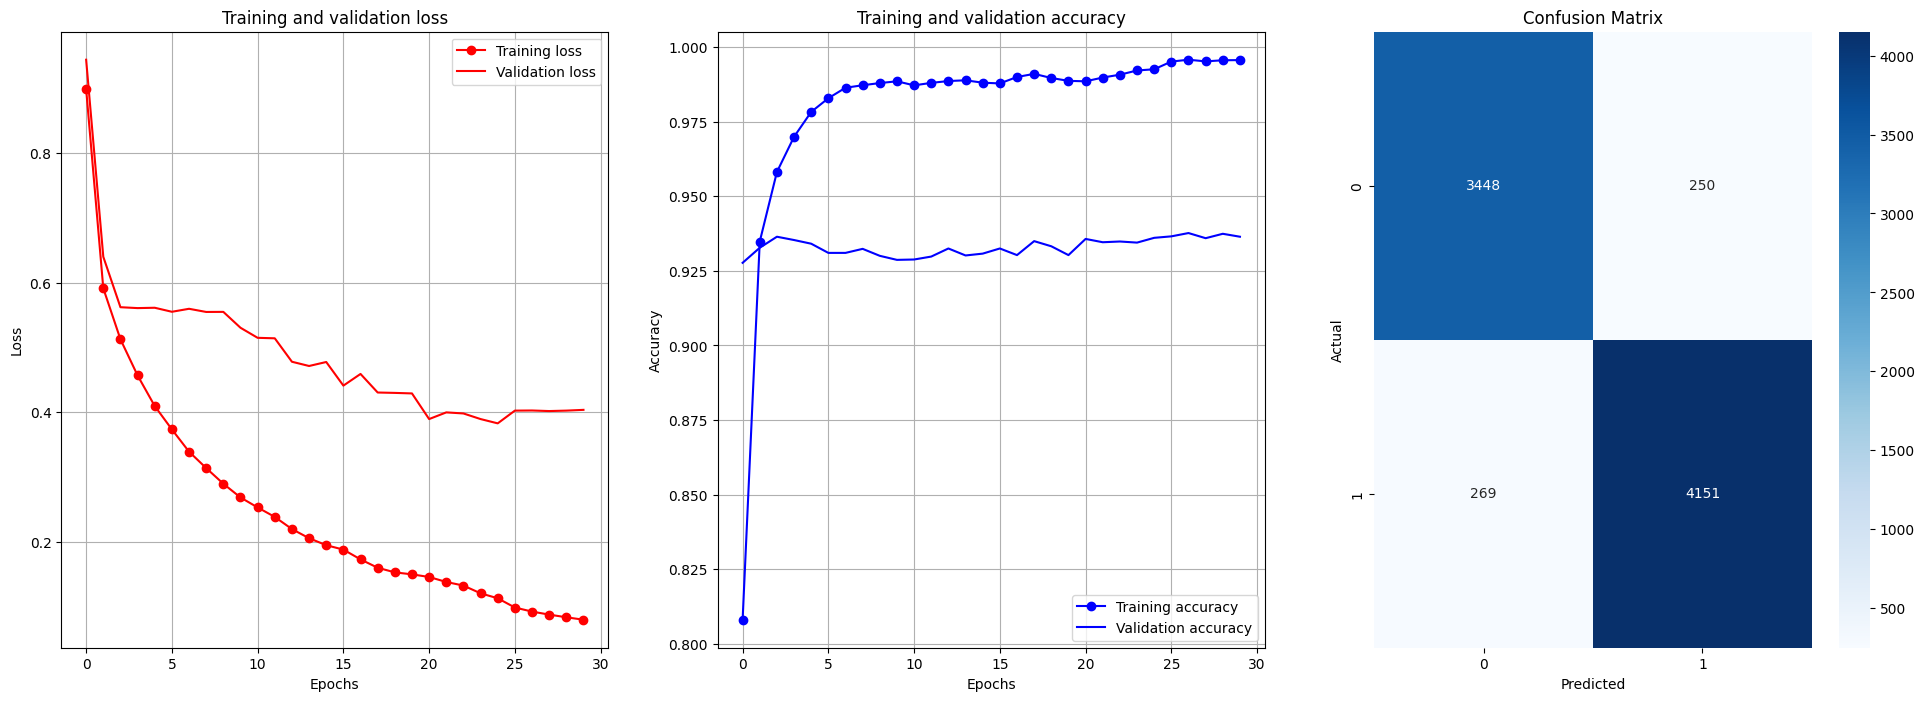

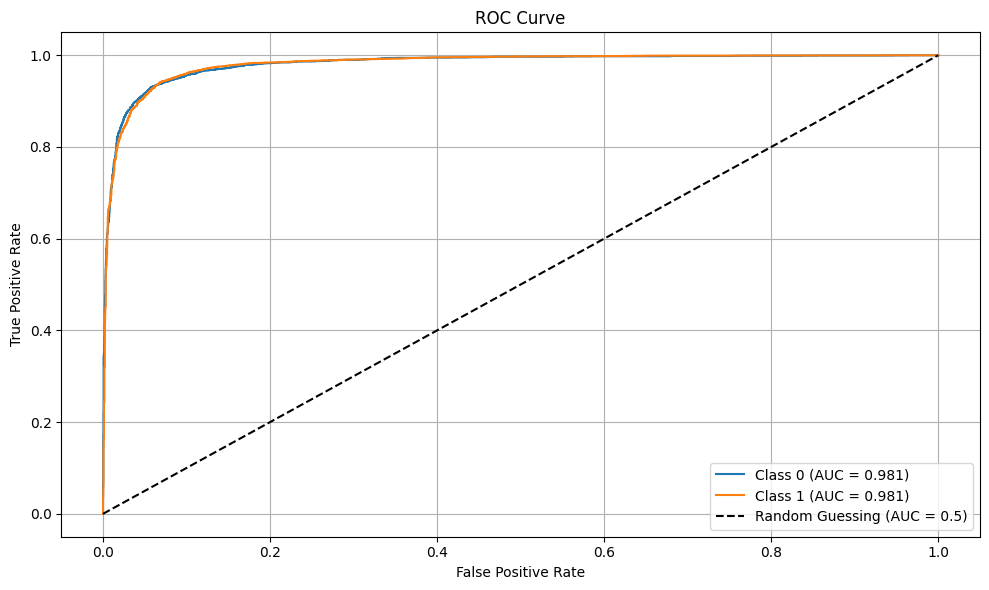

In [5]:
# Vizualizace průběhu trénování
plt.figure(figsize=(24, 8))

# Ztráta (Loss)
plt.subplot(1, 3, 1)
plt.plot(history.history["loss"], "ro-", label="Training loss")
plt.plot(history.history["val_loss"], "r-", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Přesnost (Accuracy)
plt.subplot(1, 3, 2)
plt.plot(history.history["accuracy"], "bo-", label="Training accuracy")
plt.plot(history.history["val_accuracy"], "b-", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Matice záměn (Confusion Matrix)
plt.subplot(1, 3, 3)
y_pred_classes = np.argmax(model.predict(X_test), axis=1)  # Predikce třídy
y_true = np.argmax(y_test, axis=1)  # Skutečné třídy

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(len(np.unique(y_true))), yticklabels=np.arange(len(np.unique(y_true))))
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)

# ROC Curve a AUC
plt.figure(figsize=(10, 6))
for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], model.predict(X_test)[:, i])  # Predikce pro jednotlivé třídy
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



In [4]:
# Predikce na testovacích datech
y_pred_probs = model.predict(X_test)  # Pravděpodobnosti tříd (Softmax)
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Převod pravděpodobností na třídy
y_true = np.argmax(y_test, axis=1)  # Skutečné třídy

# Výpočet metrik
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Výpis výsledků
print(f'🔹 Přesnost: {accuracy:.4f}')
print(f'🔹 Precision: {precision:.4f}')
print(f'🔹 Recall: {recall:.4f}')
print(f'🔹 F1-score: {f1:.4f}')


254/254 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step
🔹 Přesnost: 0.9361
🔹 Precision: 0.9361
🔹 Recall: 0.9361
🔹 F1-score: 0.9361
